### Clasify each frame with CNN

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 8)

i = 0
for params in resnet18.parameters():
    if i < 6:
        params.requires_grad = False
    i += 1
#summary(resnet18, (3, 224, 224))

In [3]:
batch_size = 64
n_epochs = 10

is_cpu_available = torch.cuda.is_available()

#optimizer = optim.Adam(resnet18.parameters(), lr=2e-5, weight_decay=0.0001)
optimizer = optim.SGD(resnet18.parameters(), lr=0.00002, momentum=0.95, weight_decay=0.001)
criteria = nn.CrossEntropyLoss()

In [4]:
train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(90),
            transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('./dataset1_/train', train_transforms)
val_dataset = ImageFolder('./dataset1_/val', val_transforms)
test_dataset = ImageFolder('./dataset1_/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

In [5]:
resnet18.train()

if is_cpu_available:
    resnet18.cuda()
    criteria.cuda()

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(train_loader):
        resnet18.zero_grad()
        
        img, label = data
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()

        # Forward pass
        outputs = resnet18.forward(img)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        resnet18.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(val_loader):
            img, label = data

            if is_cpu_available:
                img = img.cuda()
                label = label.cuda()

            # Test forward
            outputs = resnet18.forward(img)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    resnet18.train()
    
writer.close()

Epoch: 0 - Train Loss: 2.109883391155916 - Train Accuracy: 0.2039412558078766
Epoch: 0 - Val Loss: 1.912674682835738 - Val Accuracy: 0.33465874195098877
Epoch: 1 - Train Loss: 1.7685688145020428 - Train Accuracy: 0.39691394567489624
Epoch: 1 - Val Loss: 1.7807432152330875 - Val Accuracy: 0.3598409593105316
Epoch: 2 - Train Loss: 1.6069124698638917 - Train Accuracy: 0.47387993335723877
Epoch: 2 - Val Loss: 1.6597686658302944 - Val Accuracy: 0.4029158651828766
Epoch: 3 - Train Loss: 1.4589901026557475 - Train Accuracy: 0.5434095859527588
Epoch: 3 - Val Loss: 1.5599755651007097 - Val Accuracy: 0.44864150881767273
Epoch: 4 - Train Loss: 1.3428621502483593 - Train Accuracy: 0.6004833579063416
Epoch: 4 - Val Loss: 1.4518171641975641 - Val Accuracy: 0.5215374827384949
Epoch: 5 - Train Loss: 1.2371958466137156 - Train Accuracy: 0.6465886235237122
Epoch: 5 - Val Loss: 1.3623307642216484 - Val Accuracy: 0.5831676721572876
Epoch: 6 - Train Loss: 1.1528324190308066 - Train Accuracy: 0.674474835395

tensorboard --logdir runs

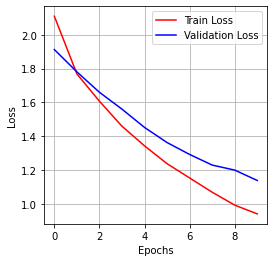

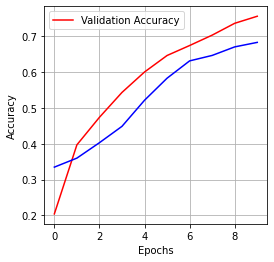

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

In [7]:
resnet18.eval()

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        img, label = data
        
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()
        
        outputs = resnet18.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)

    print('Test Accuracy: % {} '.format(correct_prediction / total))

Test Accuracy: % 0.541972279548645 
